# Fetal Health Classification

Analysis of the dataset of CTG data is the first step.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB

np.random.seed(0)

In [3]:
data = pd.read_csv("../dataset/fetal_health.csv")
data.info()
data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,133.303857,9.840844,106.0,126.000,133.000,140.000,160.000
accelerations,2126.0,0.003178,0.003866,0.0,0.000,0.002,0.006,0.019
fetal_movement,2126.0,0.009481,0.046666,0.0,0.000,0.000,0.003,0.481
uterine_contractions,2126.0,0.004366,0.002946,0.0,0.002,0.004,0.007,0.015
light_decelerations,2126.0,0.001889,0.002960,0.0,0.000,0.000,0.003,0.015
severe_decelerations,2126.0,0.000003,0.000057,0.0,0.000,0.000,0.000,0.001
prolongued_decelerations,2126.0,0.000159,0.000590,0.0,0.000,0.000,0.000,0.005
abnormal_short_term_variability,2126.0,46.990122,17.192814,12.0,32.000,49.000,61.000,87.000
mean_value_of_short_term_variability,2126.0,1.332785,0.883241,0.2,0.700,1.200,1.700,7.000
percentage_of_time_with_abnormal_long_term_variability,2126.0,9.846660,18.396880,0.0,0.000,0.000,11.000,91.000


<AxesSubplot:xlabel='fetal_health', ylabel='count'>

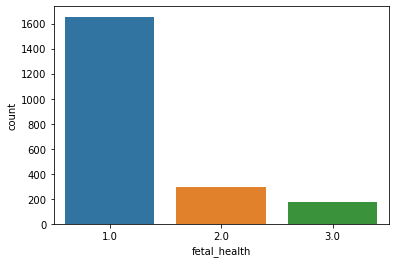

In [4]:
# Check the presence of data imbalance which requires careful attention during the validation of the final results of the models. In particular it tends to provide misleading calssification accuracy
sns.countplot(data= data, x="fetal_health")

Having verified the presence of class imbalance we will use different performance measures for our models:
* Prevision
* Accuracy 
* Recall
* Confusion Matrix
* F1 Score

<AxesSubplot:>

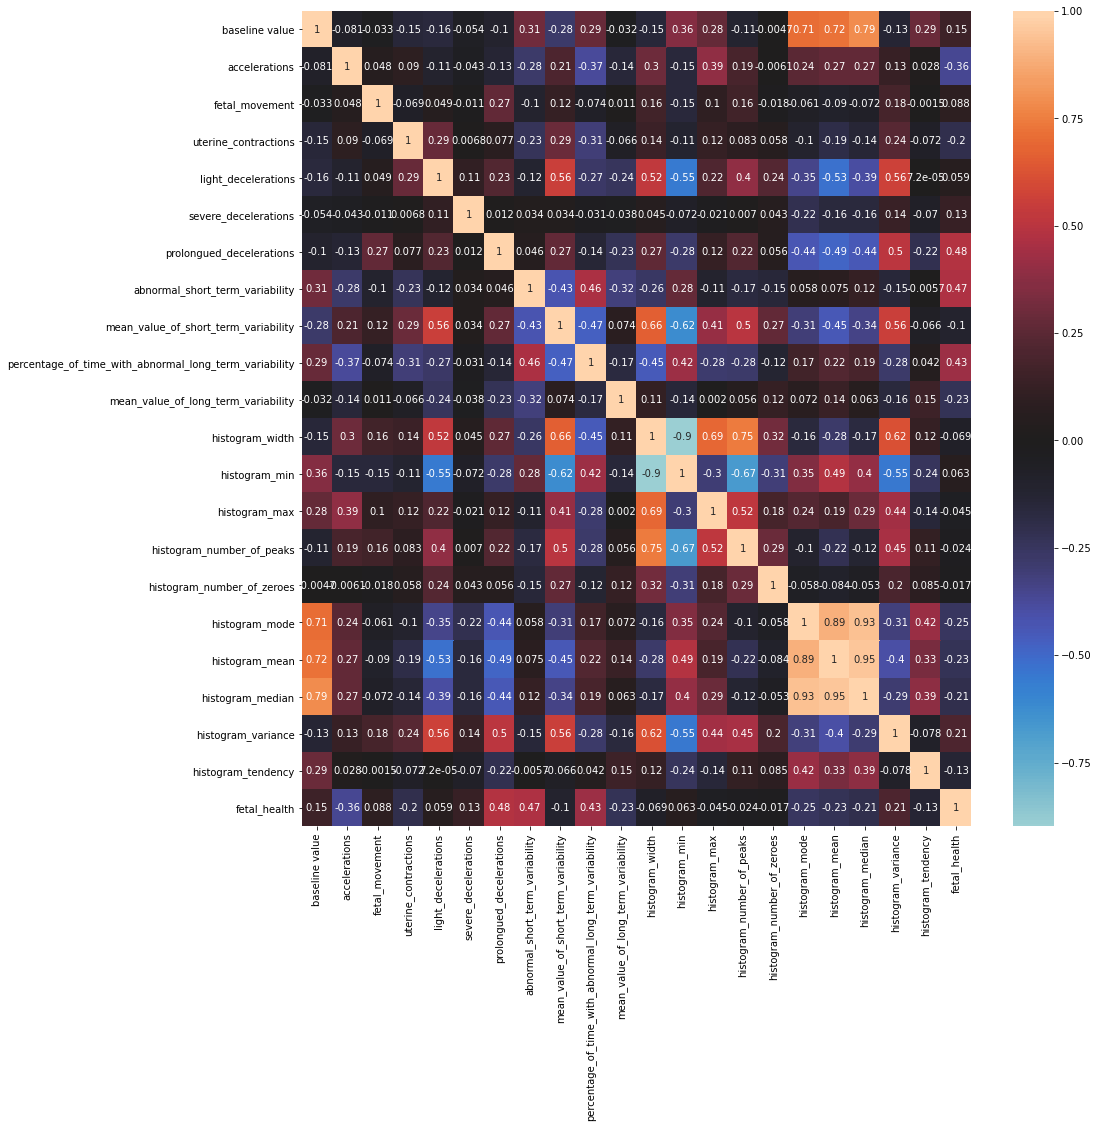

In [5]:
corrmat= data.corr()
plt.figure(figsize=(15,15))  
sns.heatmap(corrmat,annot=True,center=0)

We can that the values of "accelerations","prolongued_decelerations", "abnormal_short_term_variability", "percentage_of_time_with_abnormal_long_term_variability" and "mean_value_of_long_term_variability" are the features with high correlation with fetal_health.

# TODO maybe provide a plot of them to check the correlation and keep in mind for feature selection/ dimensionality reduction

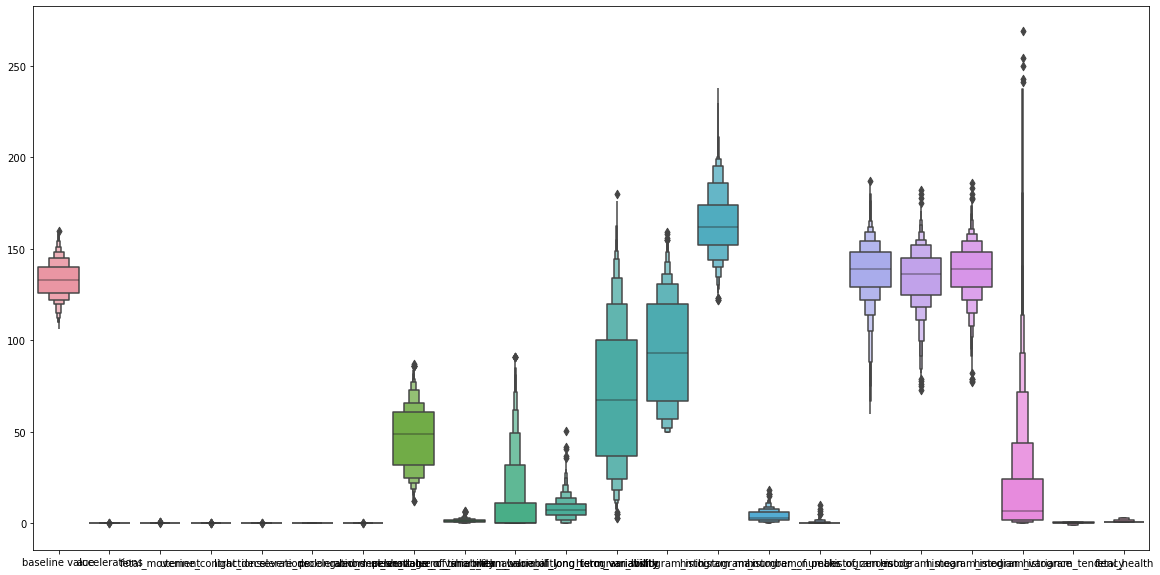

In [14]:
# Check if we need scaling of the features
plt.figure(figsize=(20,10))
sns.boxenplot(data = data)
plt.xticks(rotation=90)
plt.show()

In [13]:
X = data.drop(["fetal_health"], axis=1)
y = data["fetal_health"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=list(X.columns))
X_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2126.0,1.069490e-15,1.000235,-2.775197,-0.742373,-0.030884,0.680604,2.713428
accelerations,2126.0,-4.010589e-17,1.000235,-0.822388,-0.822388,-0.304881,0.730133,4.093929
fetal_movement,2126.0,-1.336863e-17,1.000235,-0.203210,-0.203210,-0.203210,-0.138908,10.106540
uterine_contractions,2126.0,-1.336863e-16,1.000235,-1.482465,-0.803434,-0.124404,0.894142,3.610264
light_decelerations,2126.0,-5.347452e-17,1.000235,-0.638438,-0.638438,-0.638438,0.375243,4.429965
severe_decelerations,2126.0,6.684315e-18,1.000235,-0.057476,-0.057476,-0.057476,-0.057476,17.398686
prolongued_decelerations,2126.0,1.336863e-17,1.000235,-0.268754,-0.268754,-0.268754,-0.268754,8.208570
abnormal_short_term_variability,2126.0,-7.352747e-17,1.000235,-2.035639,-0.872088,0.116930,0.815060,2.327675
mean_value_of_short_term_variability,2126.0,6.684315e-17,1.000235,-1.282833,-0.716603,-0.150373,0.415857,6.417893
percentage_of_time_with_abnormal_long_term_variability,2126.0,-5.347452e-17,1.000235,-0.535361,-0.535361,-0.535361,0.062707,4.412293


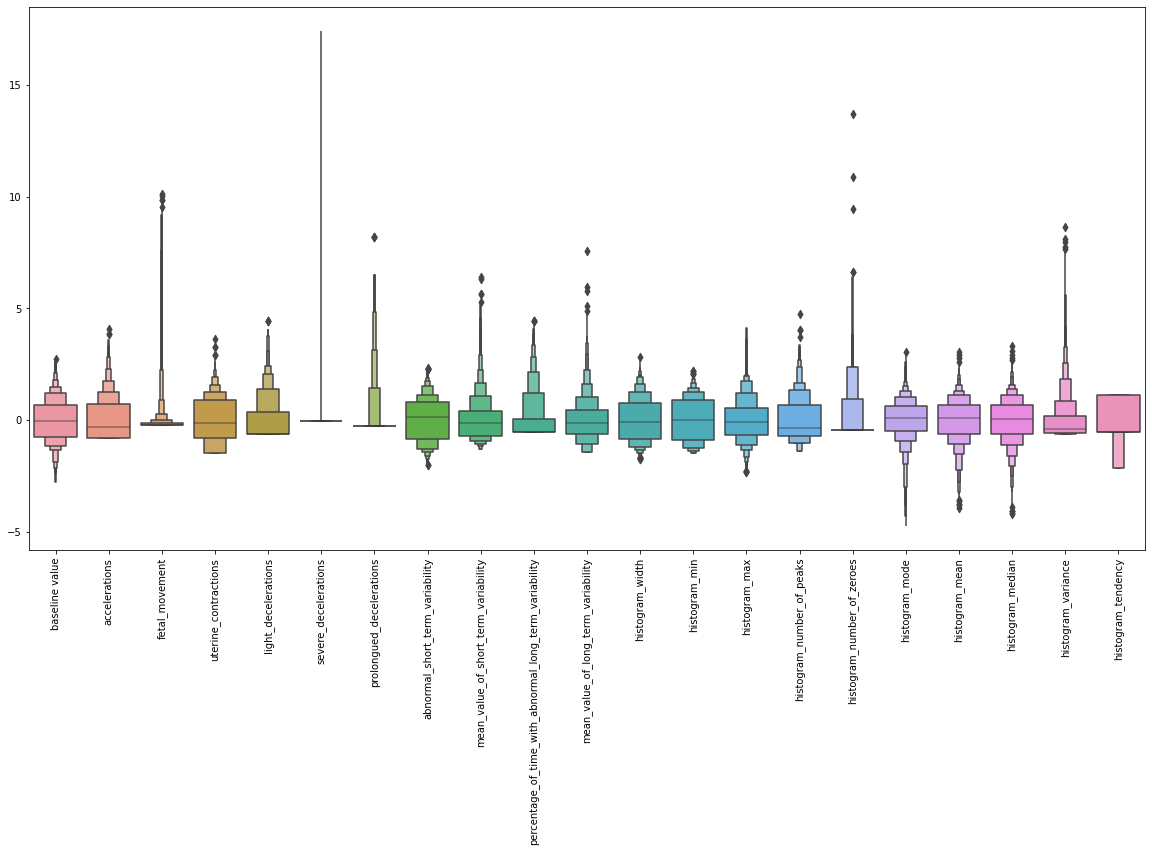

In [15]:
# Check the actual scaled version
plt.figure(figsize=(20,10))
sns.boxenplot(data = X_scaled)
plt.xticks(rotation=90)
plt.show()

In [60]:
X_train, X_test, y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

pipeline_svm_linear=Pipeline([('svm_classifier_linear',SVC(kernel='linear'))])
pipeline_svm_poly=Pipeline([('svm_classifier_poly',SVC(kernel='poly'))])
pipeline_svm_rbf=Pipeline([('svm_classifier_rbf',SVC(kernel='rbf'))])
pipeline_svm_sigmoid=Pipeline([('svm_classifier_sigmoid',SVC(kernel='sigmoid'))])
pipeline_gaussian=Pipeline([('gaussian_classifier',GaussianNB())])

pipelines = [
    pipeline_svm_linear, 
    pipeline_svm_poly, 
    pipeline_svm_rbf, 
    pipeline_svm_sigmoid,
    pipeline_gaussian,
]

pipe_dict = {
    0: 'SVM linear', 
    1: 'SVM poly', 
    2: 'SVM rbf', 
    3: "SVM sigmoid",
    4: "Gaussian NB"
}

for pipe in pipelines:
    pipe.fit(X_train, y_train)

for i, model in enumerate(pipelines):
    predictions=model.predict(X_test)
    # acccuracy= accuracy_score(y_test,predictions)
    # recall = recall_score(y_test, predictions, average="weighted")
    # precision = precision_score(y_test, predictions, average="weighted")
    # f1_score = f1_score(y_test, predictions, average="weighted")
    print("%s" % (pipe_dict[i]))
    # print("Accuracy      : ", acccuracy)
    # print("Recall        : ", recall)
    # print("Precision     : ", precision)
    # print("F1 Score      : ", f1_score)
    print(classification_report(y_test, predictions))
    plt.subplots(figsize=(12,8))
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot = True)
    plt.show()

ValueError: Negative values in data passed to MultinomialNB (input X)